In [ ]:
%pip install qiskit
%pip install qiskit-ibm-runtime
%pip install qiskit-ibm-provider

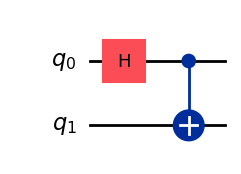

In [5]:
from qiskit import QuantumCircuit

# This initializes a 2 qubit ircuit, putting qubit 0 in superposition
# and entangling qubit 1 to it
cirq = QuantumCircuit(2)
cirq.h(0)
cirq.cx(0, 1)

cirq.draw(output='mpl')

In [6]:
from qiskit.quantum_info import Statevector

# Viewing the state vector shows the qubit positions it should be in
Statevector(cirq).draw('latex')

<IPython.core.display.Latex object>

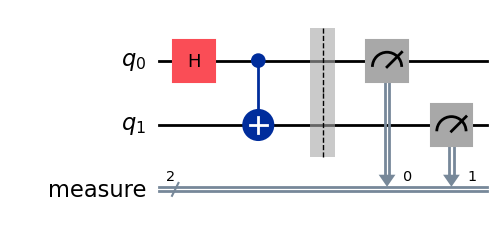

In [7]:
# Measurement converts the qubits to classical bits
cirq.measure_active()
cirq.draw(output='mpl')

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Declaring service and backend, token should be your own token on IBM Quantum
service = QiskitRuntimeService(channel='ibm_quantum', token='')
backend = service.backend('ibm_rensselaer')

In [12]:
from qiskit import generate_preset_pass_manager

# The pass manager object turns the qubits into isa_circuits, which is the way
# the sampler reads data
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

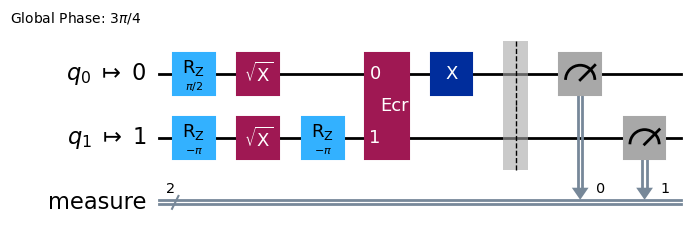

In [31]:
# Declaring ISA circuit object, or a physical circuit that uses the backend's native gates
isa_circuit = pm.run(cirq)
isa_circuit.draw(output='mpl', idle_wires=False)
# Idle wires is turned to false, otherwise all 125 ancilla qubits would've been drawn

In [17]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# The SamplerV2 would be used, since we're doing actual measurements on the quantum circuit
# If we were asking for an expectation value of the circuit, EstimatorV2 would be used
sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit])
print(f"Job ID: {job.job_id()}")

Job ID: cw8hj5r2802g0081h530


In [19]:
job.status()

'DONE'

In [27]:
# The result of the job should yield a primative result dict
result = job.result()

In [28]:
# This sequence of function calls should yield the final measurement numbers
print(result)
print(result[0])
print(result[0].data)
print(result[0].data.measure)
print(result[0].data.measure.get_counts())
data = result[0].data.measure.get_counts()

PrimitiveResult([SamplerPubResult(data=DataBin(measure=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([SliceSpan(<start='2024-10-17 14:03:08', stop='2024-10-17 14:05:01', size=4096>)])}, 'version': 2})
SamplerPubResult(data=DataBin(measure=BitArray(<shape=(), num_shots=4096, num_bits=2>)), metadata={'circuit_metadata': {}})
DataBin(measure=BitArray(<shape=(), num_shots=4096, num_bits=2>))
BitArray(<shape=(), num_shots=4096, num_bits=2>)
{'00': 2010, '11': 2053, '01': 13, '10': 20}


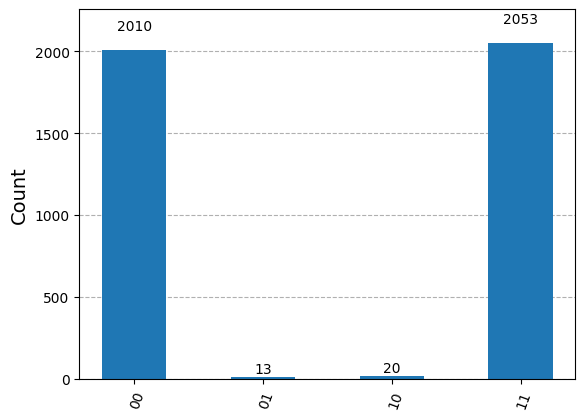

In [26]:
from qiskit.visualization import plot_histogram

#Qiskit has a default histogram plotting tool that can show the results of a job
plot_histogram(data)

The final result should show a strong amplification of the 00 and 11 states of the qubit, since it's a 50/50 chance they end up in either states. Anything else would just be interference from noise. 